<a href="https://colab.research.google.com/github/Rachhh53/NLP/blob/main/MSDS453_Assignment_01_MROnly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/djp840/MSDS_453_Public/blob/main/images/NorthwesternHeader.png?raw=1">

## MSDS453 - Research Assignment 01 - First Vectorized Representation


Our goal in this exercise is to BEGIN coming to a common agreement, among this class, as to what terms we will use as we selectively refine our corpus-wide vocabulary. This corpus vocabulary is what would represent the content of each different document for clustering and classification purposes, which will be our next step. This means that we need to make decisions - what is in, what is out.

In [182]:
import pandas as pd
import os
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import random
from dataclasses import dataclass

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer

import gensim
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE

import scipy.cluster.hierarchy

from IPython.display import display, HTML

from typing import List, Callable, Dict

### Mount Google Drive to Colab Environment

<div class="alert alert-block alert-success">
    <b>Directories Required for Research Assignment</b>:<br> 
1. Data Directory - Source Class Corpus Data<br>
2. Output Directory - Vocabulary<br>
</div>

#### Uncomment To Map Drive

In [183]:
#from google.colab import drive
#drive.mount('/content/gdrive')

### NLTK Downloads

In [184]:
# Only run this once, they will be downloaded.
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('punkt',quiet=True)
nltk.download('omw-1.4',quiet=True)

True

<div class="alert alert-block alert-danger">
<b>Gensim</b> is a Python library for topic modelling, document indexing and similarity retrieval with large corpora. Target audience is the natural language processing (NLP) and information retrieval (IR) community <br><br>
    <b>https://pypi.org/project/gensim/ </b>
</div>

In [185]:
import pkg_resources
pkg_resources.require("gensim<=3.8.3");

In [186]:
print("Genism Version: ", gensim.__version__)

Genism Version:  3.6.0


<div class="alert alert-block alert-info">
    <b>Suppress warning messages</b></div>

In [187]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## Utility Functions

In [188]:
def add_movie_descriptor(data: pd.DataFrame, corpus_df: pd.DataFrame):
    """
    Adds "Movie Description" to the supplied dataframe, in the form {Genre}_{P|N}_{Movie Title}_{DocID}
    """
    review = np.where(corpus_df['Review Type (pos or neg)'] == 'Positive', 'P', 'N')
    data['Descriptor'] = corpus_df['Genre of Movie'] + '_' + corpus_df['Movie Title'] + '_' + review + '_' + corpus_df['Doc_ID'].astype(str)

def get_corpus_df(path):
    data = pd.read_csv(path)
    add_movie_descriptor(data, data)
    sorted_data = data.sort_values(['Descriptor'])
    indexed_data = sorted_data.set_index(['Doc_ID'])
    indexed_data['Doc_ID'] = indexed_data.index
    return indexed_data

def remove_punctuation(text):
    return re.sub('[^a-zA-Z]', ' ', str(text))

def lower_case(text):
    return text.lower()    

def remove_tags(text):    
    return re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)

def remove_special_chars_and_digits(text):
    return re.sub("(\\d|\\W)+"," ", text)

@dataclass
class Document:
    doc_id: str
    text: str

def normalize_document(document: Document) -> Document:
    text = document.text
    text = remove_punctuation(text)
    text = lower_case(text)
    text = remove_tags(text)
    text = remove_special_chars_and_digits(text)
    
    return Document(document.doc_id, text)

def normalize_documents(documents: List[Document]) -> List[Document]:
    """
    Normalizes text for all given documents.
    Removes punctuation, converts to lower case, removes tags and special characters.
    """
    return [normalize_document(x) for x in documents]

@dataclass
class TokenizedDocument:
    doc_id: str
    tokens: List[str]

def tokenize_document(document: Document) -> TokenizedDocument:
    tokens = nltk.word_tokenize(document.text)
    return TokenizedDocument(document.doc_id, tokens)

def tokenize_documents(documents: List[Document]) -> List[TokenizedDocument]:
    return [tokenize_document(x) for x in documents]

def lemmatize(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
    result = []
    lemmatizer = WordNetLemmatizer()
    for document in documents:
        output_tokens = [lemmatizer.lemmatize(w) for w in document.tokens]
        result.append(TokenizedDocument(document.doc_id, output_tokens))
        
    return result

def stem(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
    result = []
    stemmer = PorterStemmer()
    for document in documents:
        output_tokens = [stemmer.stem(w) for w in document.tokens]
        result.append(TokenizedDocument(document.doc_id, output_tokens))

    return result

def remove_stop_words(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
    result = []
    
    stop_words = set(nltk.corpus.stopwords.words('english')) 
    for document in documents:
        filtered_tokens = [w for w in document.tokens if not w in stop_words]
        result.append(TokenizedDocument(document.doc_id, filtered_tokens))
        
    return result
    
def add_flags(data: pd.DataFrame, minority_report_doc_ids: List[int], scifi_doc_ids: List[int]):
    data['is_minority_report'] = data.index.isin(minority_report_doc_ids)
    data['is_scifi'] = data.index.isin(scifi_doc_ids)
    
def get_all_tokens(documents: List[TokenizedDocument]) -> List[str]:
    tokens = {y for x in documents for y in x.tokens}
    return sorted(list(tokens))

## Loading the corpus

In [189]:
CORPUS_PATH = 'RSV_Movie_Reviews_refomattedMod3.csv'
corpus_df = get_corpus_df(CORPUS_PATH)
documents = [Document(x, y) for x, y in zip(corpus_df.Doc_ID, corpus_df.Text)]

1. Dataframe = corpus_df
2. List = documents (Document ID, Text)

## Exploritory Data Analysis

In [190]:
corpus_df.shape

(10, 9)

In [191]:
corpus_df.head().T

Doc_ID,5,6,7,8,9
DSI_Title,RSV_Doc6_MinorityReport,RSV_Doc7_MinorityReport,RSV_Doc8_MinorityReport,RSV_Doc9_MinorityReport,RSV_Doc10_MinorityReport
Text,"Minority Report , directed by Steven Spielberg...",Once again this year we are graced with a futu...,"Set in the year 2054, Steven Spielberg's Minor...","In Minority Report, a futuristic thriller set ...","What new hell is this? In the shallow, noisy a..."
Submission File Name,NaN,NaN,NaN,NaN,NaN
Student Name,RS,RS,RS,RS,RS
Genre of Movie,Sci-Fi,Sci-Fi,Sci-Fi,Sci-Fi,Sci-Fi
Review Type (pos or neg),Negative,Negative,Negative,Negative,Negative
Movie Title,Minority Report,Minority Report,Minority Report,Minority Report,Minority Report
Descriptor,Sci-Fi_Minority Report_N_5,Sci-Fi_Minority Report_N_6,Sci-Fi_Minority Report_N_7,Sci-Fi_Minority Report_N_8,Sci-Fi_Minority Report_N_9
Doc_ID,5,6,7,8,9


In [192]:
print(corpus_df.info());

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 5 to 4
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   DSI_Title                 10 non-null     object 
 1   Text                      10 non-null     object 
 2   Submission File Name      0 non-null      float64
 3   Student Name              10 non-null     object 
 4   Genre of Movie            10 non-null     object 
 5   Review Type (pos or neg)  10 non-null     object 
 6   Movie Title               10 non-null     object 
 7   Descriptor                10 non-null     object 
 8   Doc_ID                    10 non-null     int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 800.0+ bytes
None


In [193]:
print(corpus_df['Movie Title'].unique())

['Minority Report']


## Number of Reviews By Genre

In [194]:
counts_df = corpus_df[['Genre of Movie']].copy()
counts_df['Count'] = 1
counts_df.groupby(['Genre of Movie']).count().reset_index()

,Genre of Movie,Count
0,Sci-Fi,10


In [195]:
corpus_df.columns

Index(['DSI_Title', 'Text', 'Submission File Name', 'Student Name',
       'Genre of Movie', 'Review Type (pos or neg)', 'Movie Title',
       'Descriptor', 'Doc_ID'],
      dtype='object')

## Normalized Document

1. remove_punctuation(text)
2. lower_case(text)
3. remove_tags(text)
4. remove_special_chars_and_digits(text)
5. return Document(document.doc_id, text)

In [196]:
normalized_documents = normalize_documents(documents)
normalized_documents[0]

Document(doc_id=5, text='minority report directed by steven spielberg screenplay by scott frank and jon cohen based on a short story by philip k dickminority report is the latest film directed by steven spielberg in the year murder has been eliminated in washington dc through the use of a team of psychics who infallibly foresee killings the would be murderers are apprehended before they commit their crimes and sent to cryogenic freezing units when the leading figure in the pre crime unit john anderton tom cruise is named as the future killer of a man he does not know he sets out to unravel the mystery with his own police force hot on his trail anderton s own son was abducted and presumably murdered some years before an event that also shattered his marriage spielberg is one of the more gifted members of a generation of studio filmmakers whose output in general has been exceedingly poor and forgettable he has the undoubted ability to narrate a drama effectively to hold the spectator s a

## Standardize Document

#### NLTK Tokenizer Package

https://www.nltk.org/api/nltk.tokenize.html

Tokenizers divide strings into lists of substrings. For example, tokenizers can be used to find the words and punctuation in a string:

### Functions for Tokenization Process
1. tokenize_document
2. tokenize_documents

In [197]:
tokenized_documents = tokenize_documents(normalized_documents)
tokenized_documents[0]

TokenizedDocument(doc_id=5, tokens=['minority', 'report', 'directed', 'by', 'steven', 'spielberg', 'screenplay', 'by', 'scott', 'frank', 'and', 'jon', 'cohen', 'based', 'on', 'a', 'short', 'story', 'by', 'philip', 'k', 'dickminority', 'report', 'is', 'the', 'latest', 'film', 'directed', 'by', 'steven', 'spielberg', 'in', 'the', 'year', 'murder', 'has', 'been', 'eliminated', 'in', 'washington', 'dc', 'through', 'the', 'use', 'of', 'a', 'team', 'of', 'psychics', 'who', 'infallibly', 'foresee', 'killings', 'the', 'would', 'be', 'murderers', 'are', 'apprehended', 'before', 'they', 'commit', 'their', 'crimes', 'and', 'sent', 'to', 'cryogenic', 'freezing', 'units', 'when', 'the', 'leading', 'figure', 'in', 'the', 'pre', 'crime', 'unit', 'john', 'anderton', 'tom', 'cruise', 'is', 'named', 'as', 'the', 'future', 'killer', 'of', 'a', 'man', 'he', 'does', 'not', 'know', 'he', 'sets', 'out', 'to', 'unravel', 'the', 'mystery', 'with', 'his', 'own', 'police', 'force', 'hot', 'on', 'his', 'trail', '

## Useful Lookups (Titles by DocID, Genres by DocID, Description by DocID)

In [198]:
titles_by_doc_ids = {x: y for x, y in zip(corpus_df['Doc_ID'], corpus_df['Movie Title'])}
genres_by_doc_ids = {x: y for x, y in zip(corpus_df['Doc_ID'], corpus_df['Genre of Movie'])}
descriptors_by_doc_ids = {x: y for x, y in zip(corpus_df['Doc_ID'], corpus_df['Descriptor'])}

scifi_doc_ids = [int(x) for x in corpus_df['Doc_ID'] if genres_by_doc_ids[x] == 'Sci-Fi']
scifi_documents = [x for x in documents if x.doc_id in scifi_doc_ids]

non_scifi_doc_ids = {int(x) for x in corpus_df['Doc_ID'] if genres_by_doc_ids[x] != 'Sci-Fi'}
non_scifi_documents = [x for x in documents if x.doc_id in non_scifi_doc_ids]

## Lookup for Specific Movie Title

In [199]:
print(corpus_df['Movie Title'].unique())

['Minority Report']


In [200]:
minority_report_doc_ids = [int(x) for x in corpus_df['Doc_ID'] if titles_by_doc_ids[x] == 'Minority Report']
minority_report_documents = [x for x in documents if x.doc_id in minority_report_doc_ids]

## Qualitative Term Determinations

#### Terms Determined by Document of Interest

In [201]:
candidate_terms = [
    'precrime',
    'precog',
    'future',
    'minority report', # I think bigrams won't work here
    'predict',
    'tech',
    'murder',
    'hitchcock',
    'spielberg',
    'anderton',
    'dick',
    'agatha',
    'dc',
    'crime',
    'cruise'
]

## CountVectorizer

<div class="alert alert-block alert-success">
    <b>sklearn.feature_extraction.text.CountVectorizer</b>:<br> 
Convert a collection of text documents to a matrix of token counts.<br>
This implementation produces a sparse representation of the counts using scipy.sparse.csr_matrix.<br>
If you do not provide an a-priori dictionary and you do not use an analyzer that does some kind of feature selection then the number of features will be equal to the vocabulary size found by analyzing the data.
</div>

In [202]:
vectorizer = CountVectorizer(ngram_range=(1, 1))
text_for_counts = [x.text for x in normalized_documents]
matrix = vectorizer.fit_transform(text_for_counts)
words = vectorizer.get_feature_names_out()
word_counts = pd.DataFrame(matrix.toarray(), columns=words, index=corpus_df.Doc_ID)

In [203]:
add_flags(word_counts, minority_report_doc_ids, scifi_doc_ids)
word_counts['Doc_ID'] = word_counts.index

In [204]:
# Collect result into a dataframe
mean_frequencies = pd.DataFrame(index=candidate_terms)

minority_report_mean_frequencies = word_counts[word_counts.is_minority_report][[x for x in candidate_terms if x in word_counts.columns]].mean()
mean_frequencies['Minority Report'] = minority_report_mean_frequencies

# action_mean_frequencies = word_counts[word_counts.is_action][[x for x in candidate_terms if x in word_counts.columns]].mean()
# mean_frequencies['All Action'] = action_mean_frequencies

# non_action_mean_frequencies = word_counts[~word_counts.is_action][[x for x in candidate_terms if x in word_counts.columns]].mean()
# mean_frequencies['All Non-Action'] = non_action_mean_frequencies

scifi_mean_frequencies = word_counts[word_counts.is_scifi][[x for x in candidate_terms if x in word_counts.columns]].mean()
mean_frequencies['All Sci-Fi'] = scifi_mean_frequencies

non_scifi_mean_frequencies = word_counts[~word_counts.is_scifi][[x for x in candidate_terms if x in word_counts.columns]].mean()
mean_frequencies['All Non-Sci-Fi'] = non_scifi_mean_frequencies

In [205]:
mean_frequencies.fillna(0.0).sort_values(['Minority Report'], ascending=False)

,Minority Report,All Sci-Fi,All Non-Sci-Fi
spielberg,7.80,7.80,0.00
anderton,7.70,7.70,0.00
cruise,4.20,4.20,0.00
future,3.80,3.80,0.00
crime,3.70,3.70,0.00
precrime,3.20,3.20,0.00
murder,2.40,2.40,0.00
dick,2.30,2.30,0.00
agatha,1.30,1.30,0.00
hitchcock,1.20,1.20,0.00


In [206]:
# These are identified
important_prevalent_terms = [
    'precog',
    'crime',
    'future',
    'tech'
]
stemmer = PorterStemmer()
stemmed_important_prevalent_terms = [stemmer.stem(x) for x in important_prevalent_terms]

In [207]:
pd.options.display.float_format = '{:,.2f}'.format
mean_frequencies.fillna(0.0).loc[important_prevalent_terms].round(2).sort_values(['Minority Report'], ascending=False)

,Minority Report,All Sci-Fi,All Non-Sci-Fi
future,3.80,3.80,0.00
crime,3.70,3.70,0.00
precog,0.50,0.50,0.00
tech,0.30,0.30,0.00


## TF-IDF Experiment Functions - Text Normalization

In [208]:
def run_tfidf(documents: List[Document],
              clean_func: Callable[[List[Document]], List[TokenizedDocument]],
              important_prevalent_terms: List[str],
              experiment_name: str,
              output_tfidf_vectors: bool=False,
              output_vocabulary: bool=True):
    cleaned_documents = clean_func(documents)
    cleaned_document_text = [' '.join(x.tokens) for x in cleaned_documents]
    
    vectorizer = TfidfVectorizer(use_idf=True,
                                 ngram_range=(1, 1),
                                 norm=None)

    transformed_documents = vectorizer.fit_transform(cleaned_document_text)
    transformed_documents_as_array = transformed_documents.toarray()

    output_dir = f'output/{experiment_name}_Results'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    if output_tfidf_vectors:
        for counter, doc in enumerate(transformed_documents_as_array):
            tf_idf_tuples = list(zip(vectorizer.get_feature_names_out(), doc))
            one_doc_as_df = pd.DataFrame.from_records(tf_idf_tuples, columns=['term', 'score'])\
                                        .sort_values(by='score', ascending=False)\
                                        .reset_index(drop=True)

            one_doc_as_df.to_csv(f'{output_dir}/{corpus_df["Submission File Name"][counter]}')
    
    if output_vocabulary:
        with open(f'{output_dir}/vocabulary.txt', 'w') as vocab:
            words = sorted(vectorizer.get_feature_names_out())
            print('\n'.join(words), file=vocab)

    # Create document-term dataframe
    doc_term_matrix = transformed_documents.todense()
    doc_term_df = pd.DataFrame(doc_term_matrix, 
                               columns=vectorizer.get_feature_names_out(), 
                               index=corpus_df.Doc_ID)
    add_flags(doc_term_df, minority_report_doc_ids, scifi_doc_ids)
    
    # Print the top 10 mean TF-IDF values
    top10_tfidf = pd.DataFrame(doc_term_df.mean().sort_values(ascending=False).head(10))
    top10_tfidf.rename(columns={0: 'Mean TF-IDF'}, inplace=True)
    display(top10_tfidf)
    
    # Collect result into a dataframe
    tfidf_results = pd.DataFrame(index=important_prevalent_terms)
 
    all_tfidf_results = doc_term_df[[x for x in important_prevalent_terms if x in doc_term_df.columns]].mean().round(2)
    tfidf_results['All Movies'] = all_tfidf_results
    
    plt.hist(doc_term_df.mean(), 100, range=(0, 8))
    
    print(f'Vocabulary size: {doc_term_df.shape[1]}')
    
    descriptors = corpus_df['Descriptor']
       
    similarities = cosine_similarity(doc_term_df.loc[scifi_doc_ids], doc_term_df.loc[scifi_doc_ids])
    fig, ax = plt.subplots(figsize=(30, 30))
    labels = [descriptors_by_doc_ids[x.doc_id] for x in scifi_documents]
    sns.heatmap(ax=ax, data=similarities, xticklabels=labels, yticklabels=labels)
    #plt.savefig(f'figures/{experiment_name}_heatmap_documents.png')
    plt.show()

## TF-IDF  (Term Frequency-Inverse Document Frequency)

### Experiments, Normalize, Tokenize, Lemmatization and Stop Word Removal

In [209]:
def clean_method(documents: List[Document]) -> List[TokenizedDocument]:
    """
    Normalizes text, tokenizes, lemmatizes, and removes stop words.
    """
    documents = normalize_documents(documents)
    documents = tokenize_documents(documents)
    documents = lemmatize(documents)
    documents = remove_stop_words(documents)
    documents = stem(documents)
        
    return documents

,Mean TF-IDF
film,9.37
anderton,8.43
report,8.11
spielberg,7.90
minor,7.67
pre,5.93
one,5.70
movi,5.59
crime,4.71
precrim,4.65


Vocabulary size: 2695


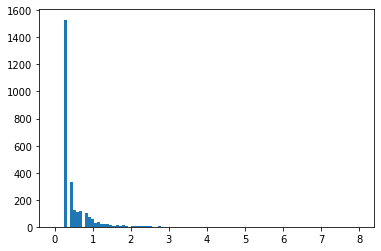

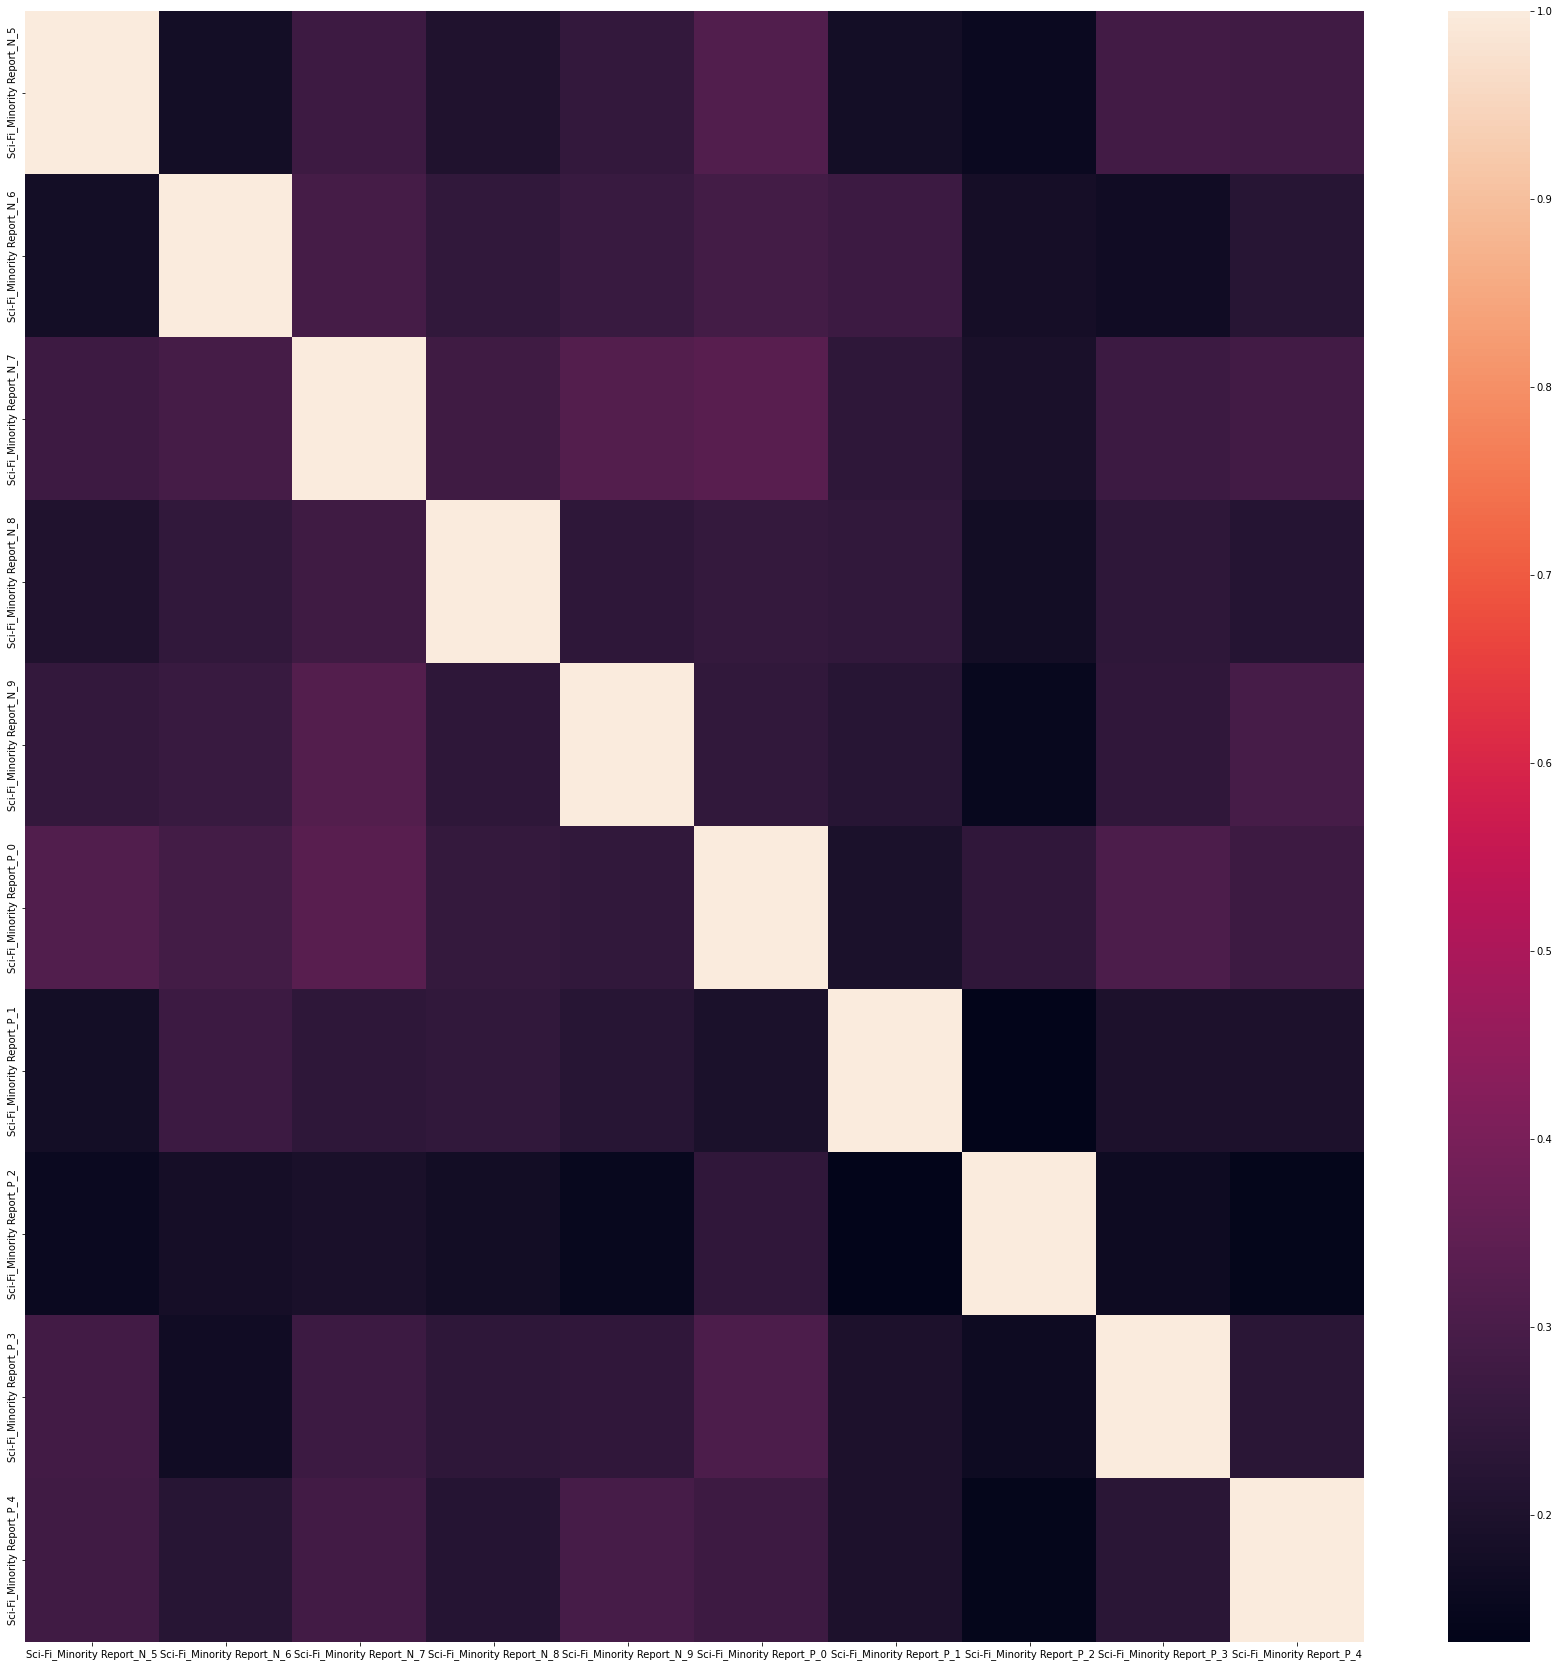

In [210]:
run_tfidf(documents, clean_method, important_prevalent_terms, 'TFIDF_exp')

## Word2Vec

<div class="alert alert-block alert-success">
    <b>Word2vec embeddings</b>: https://radimrehurek.com/gensim/models/word2vec.html <br>
    This module implements the word2vec family of algorithms, using highly optimized C routines, data streaming and Pythonic interfaces.
            </div>

## Utility Functions For Word2Vec Experiments

In [211]:
def get_word2vec_vectors(documents: List[TokenizedDocument], embedding_size: int) -> pd.DataFrame:
    tokens = [x.tokens for x in documents]
    
    word2vec_model = Word2Vec(tokens, size=embedding_size, window=3, min_count=1, workers=12)
    
    vectors = {}
    for i in word2vec_model.wv.vocab:
        temp_vec = word2vec_model.wv[i]
        vectors[i] = temp_vec

    result = pd.DataFrame(vectors).transpose()
    result = result.sort_index()
    return result
   
def plot_similarity_matrix(data: pd.DataFrame, experiment_name: str, figsize=(25, 25)):
    similarities = cosine_similarity(data, data)
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(ax=ax, data=similarities, xticklabels=data.index, yticklabels=data.index);
    #plt.savefig(f'figures/{experiment_name}_heatmap.png')
    plt.close()
    
def plot_similarity_clustermap(data: pd.DataFrame, experiment_name: str, figsize=(25, 25)):
    similarities = cosine_similarity(data, data)
    cm = sns.clustermap(similarities, metric='cosine', xticklabels=data.index, yticklabels=data.index, method='complete', cmap='RdBu', figsize=figsize)
    cm.ax_row_dendrogram.set_visible(False)
    cm.ax_col_dendrogram.set_visible(False)
    plt.legend(loc='upper left')
    #plt.savefig(f'figures/{experiment_name}_clustermap.png')
    plt.show()
    plt.close()

def plot_tsne(data: pd.DataFrame, perplexity: int, experiment_name: str, figsize=(40, 40)):
    """
    Creates a TSNE plot of the supplied dataframe
    """
    tsne_model = TSNE(perplexity=perplexity, n_components=2, learning_rate='auto', init='pca', n_iter=1000, random_state=32)
    new_values = tsne_model.fit_transform(data)
    
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=figsize)
    labels = list(data.index)
    for i in range(len(x)):
        new_value = new_values[i]
        x = new_value[0]
        y = new_value[1]
        
        plt.scatter(x, y)
        plt.annotate(labels[i],
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    #plt.savefig(f'figures/{experiment_name}_tsne.png')
    plt.show()
    plt.close()
    
def run_word2vec_experiment(documents: List[Document],
                            clean_func: Callable[[List[Document]], List[TokenizedDocument]],
                            embedding_size: int,
                            chosen_tokens: List[str],
                            experiment_name: str):
    cleaned_documents = clean_func(documents)

    word2vec_df = get_word2vec_vectors(cleaned_documents, embedding_size)
    filtered_word2vec_df = word2vec_df.loc[chosen_tokens].copy()

    plot_tsne(filtered_word2vec_df, 30, experiment_name)
    plot_similarity_matrix(filtered_word2vec_df, experiment_name)
    plot_similarity_clustermap(filtered_word2vec_df, experiment_name)

In [212]:
extra_terms = [
    'retina',
    'thriller',
    'noir'
]

In [213]:
# Get our terms to examine in experiements 4-12
all_tokens = get_all_tokens(remove_stop_words(clean_method(documents)))
chosen_tokens = random.choices(all_tokens, k=100 - len(extra_terms)) + extra_terms

lemmatizer = WordNetLemmatizer()
lemmatized_chosen_tokens = [lemmatizer.lemmatize(x) for x in chosen_tokens]
stemmed_chosen_tokens = [stemmer.stem(x) for x in lemmatized_chosen_tokens]

## Word2Vec Experiments: 


<div class="alert alert-block alert-success">
    <b>Word2vec embeddings</b>: https://radimrehurek.com/gensim/models/word2vec.html <br>
    This module implements the word2vec family of algorithms, using highly optimized C routines, data streaming and Pythonic interfaces.
            </div>

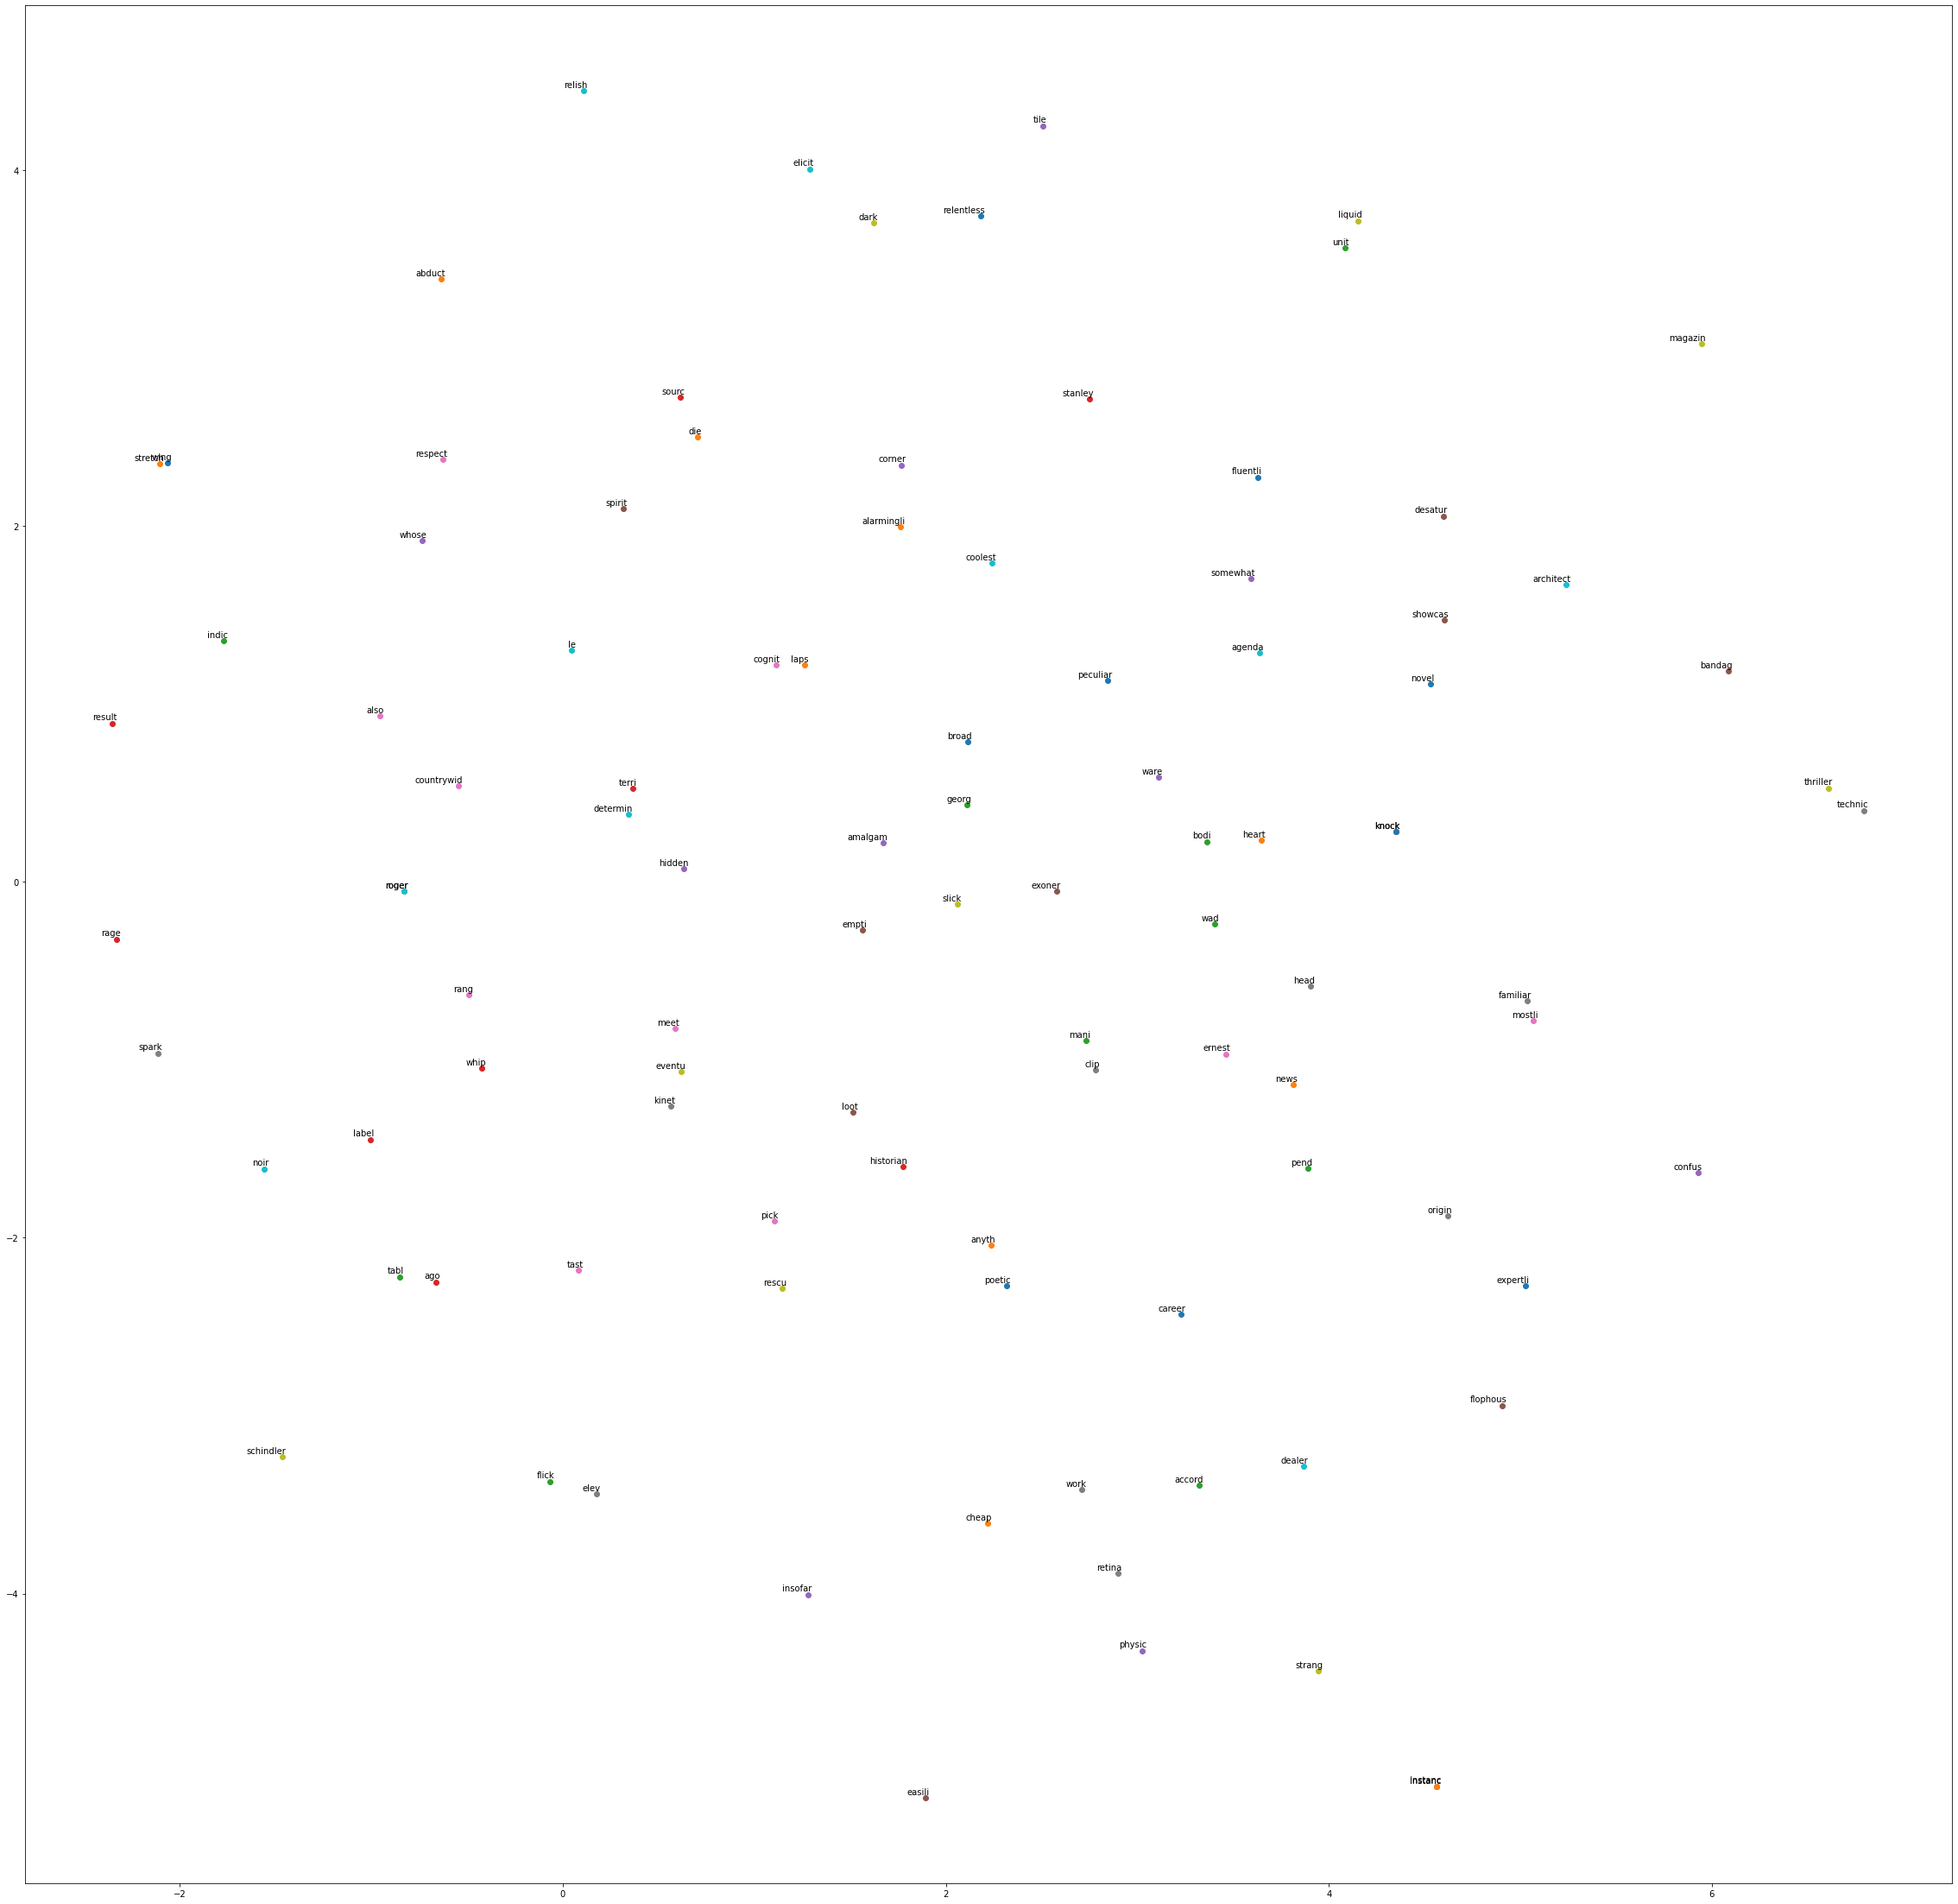

No handles with labels found to put in legend.


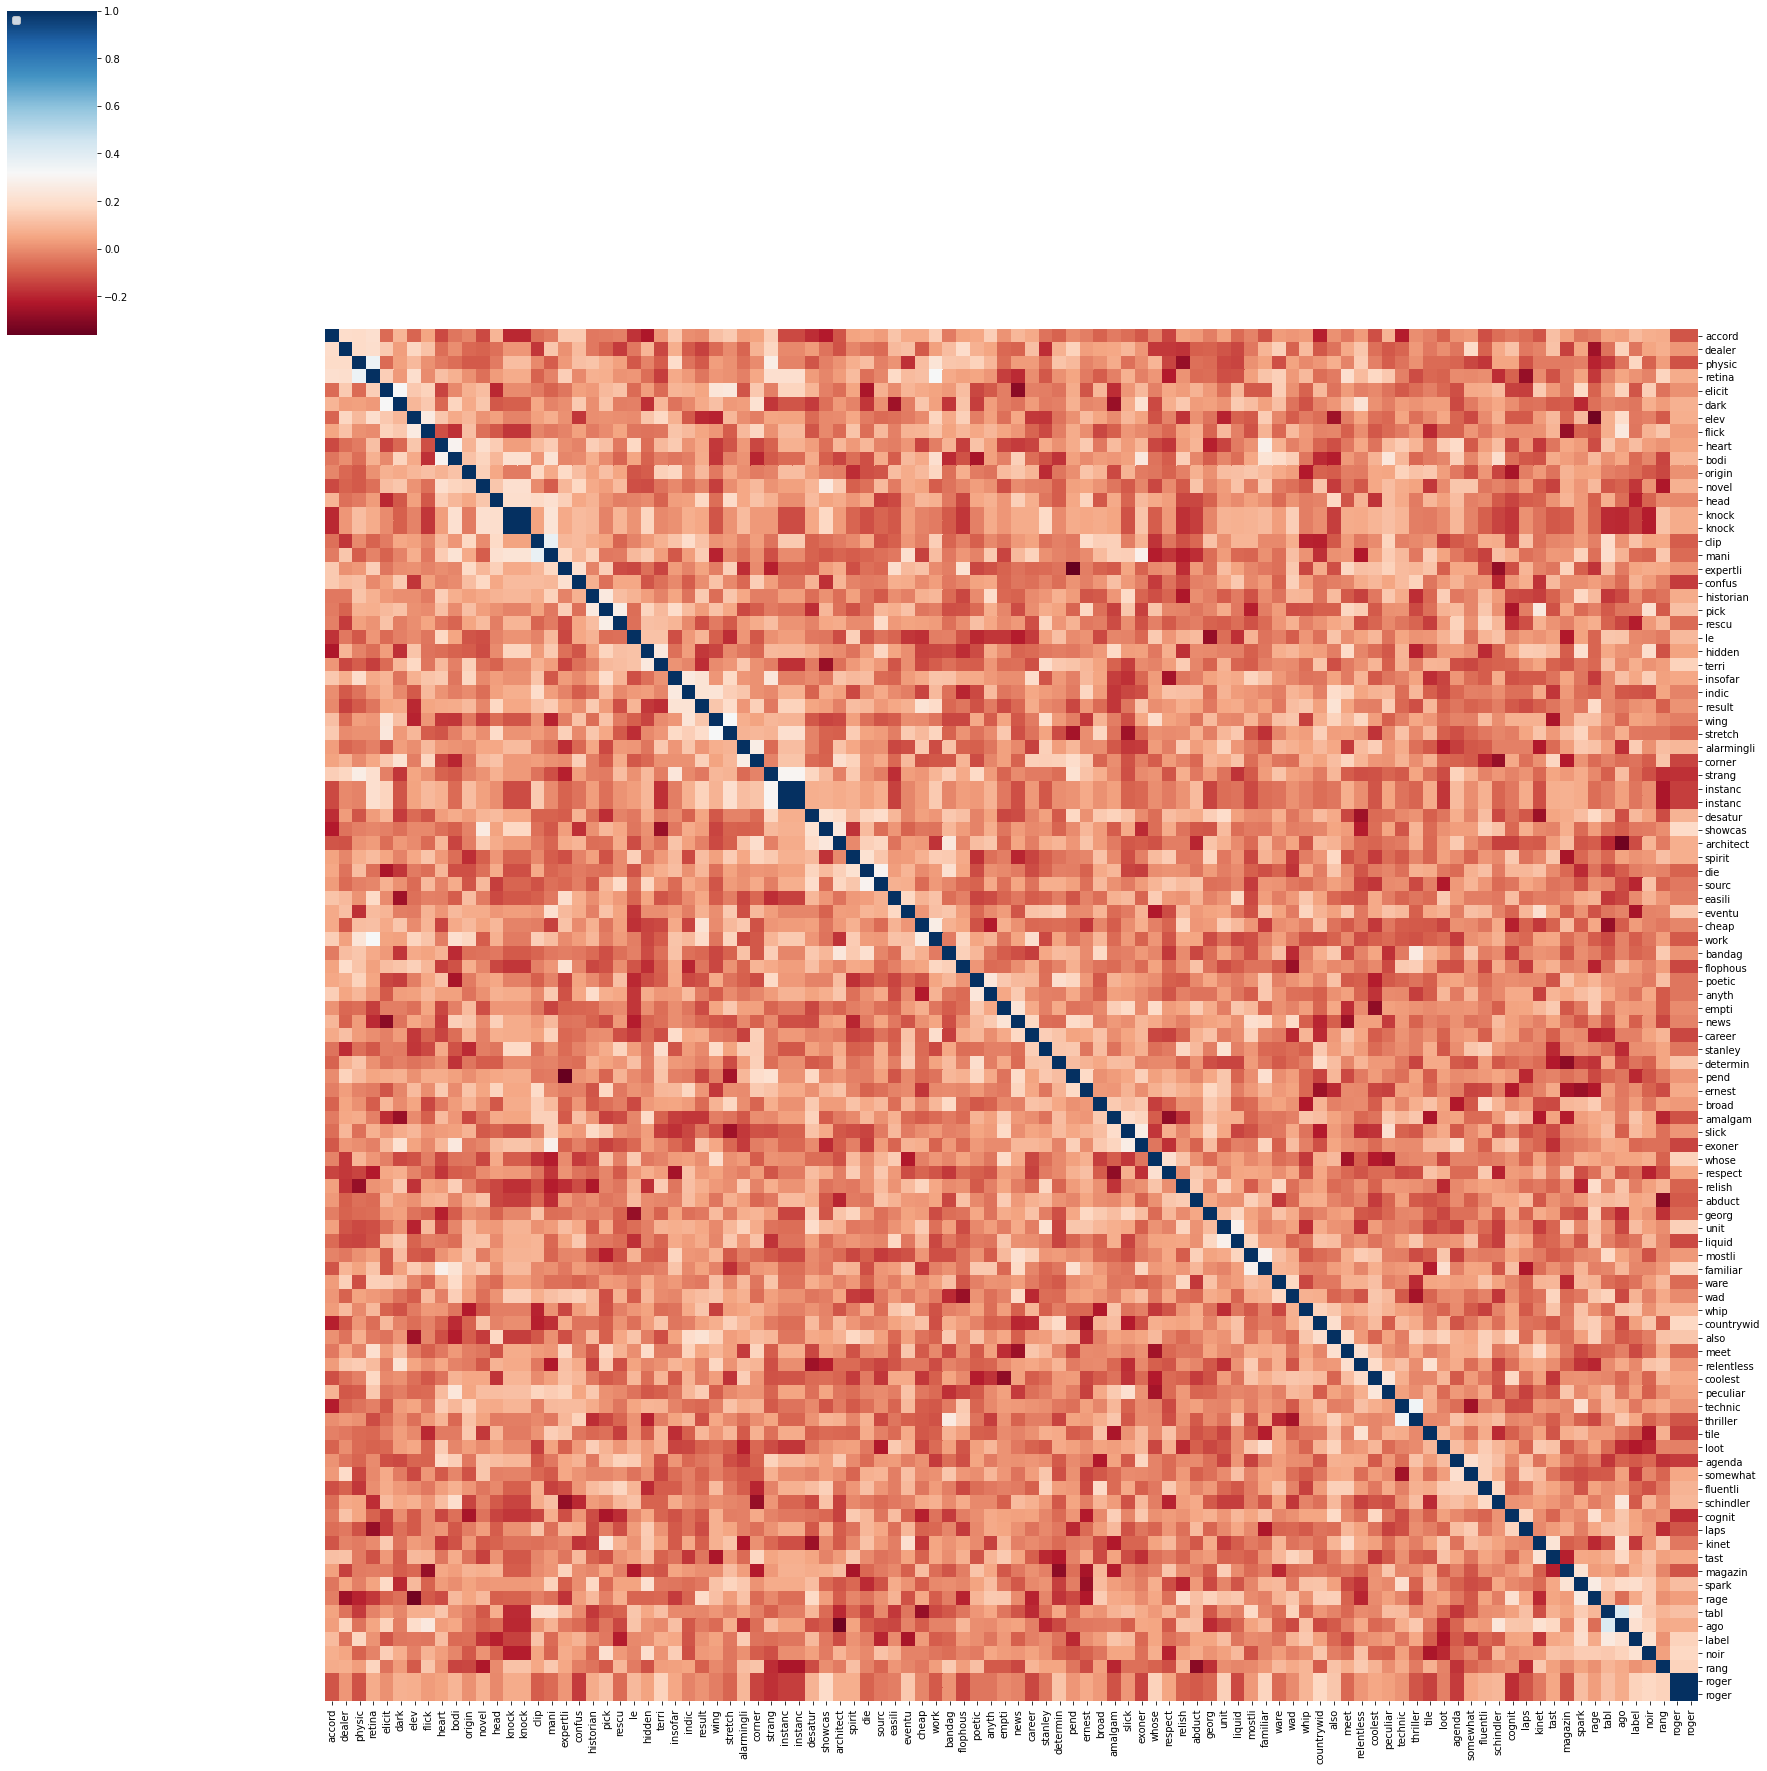

In [214]:
run_word2vec_experiment(documents, clean_method, 100, chosen_tokens, 'Word2Vec_exp')

## Utility functions for Doc2Vec experiments

<div class="alert alert-block alert-success">
    <b>Doc2vec Paragraph Embeddings</b>: https://radimrehurek.com/gensim/models/doc2vec.html <br>
    Paragraph and document embeddings via the distributed memory and distributed bag of words models from Quoc Le and Tomas Mikolov: “Distributed Representations of Sentences and Documents”. <br>

The algorithms use either hierarchical softmax or negative sampling;
            </div>

In [215]:
def run_doc2vec(documents: List[TokenizedDocument], embedding_size: int, descriptors_by_doc_ids: Dict[int, str]):
    tagged_documents = [TaggedDocument(document.tokens, [i]) for i, document in enumerate(documents)]
    doc2vec_model = Doc2Vec(tagged_documents, vector_size=embedding_size, window=3, min_count=2, workers=12)    
    
    doc2vec_df = pd.DataFrame()
    for document in documents:
        vector = pd.DataFrame(doc2vec_model.infer_vector(document.tokens)).transpose()
        doc2vec_df = pd.concat([doc2vec_df, vector], axis=0)
    
    doc2vec_df['Descriptor'] = [descriptors_by_doc_ids[x.doc_id] for x in documents]
    doc2vec_df.set_index(['Descriptor'], inplace=True)
    return doc2vec_df

def run_doc2vec_experiment(documents: List[Document],
                           clean_func: Callable[[List[Document]], List[TokenizedDocument]],
                           embedding_size: int,
                           experiment_name: str):
    cleaned_documents = clean_func(documents)
    doc2vec_df = run_doc2vec(cleaned_documents, embedding_size, descriptors_by_doc_ids)
    
    plot_similarity_matrix(doc2vec_df, experiment_name)
    plot_similarity_clustermap(doc2vec_df, experiment_name, figsize=(50, 50))
    plot_tsne(doc2vec_df, 30, experiment_name)

## Doc2Vec Experiments:

<div class="alert alert-block alert-success">
    <b>Doc2vec Paragraph Embeddings</b>: https://radimrehurek.com/gensim/models/doc2vec.html <br>
    Paragraph and document embeddings via the distributed memory and distributed bag of words models from Quoc Le and Tomas Mikolov: “Distributed Representations of Sentences and Documents”. <br>

The algorithms use either hierarchical softmax or negative sampling;
            </div>

No handles with labels found to put in legend.


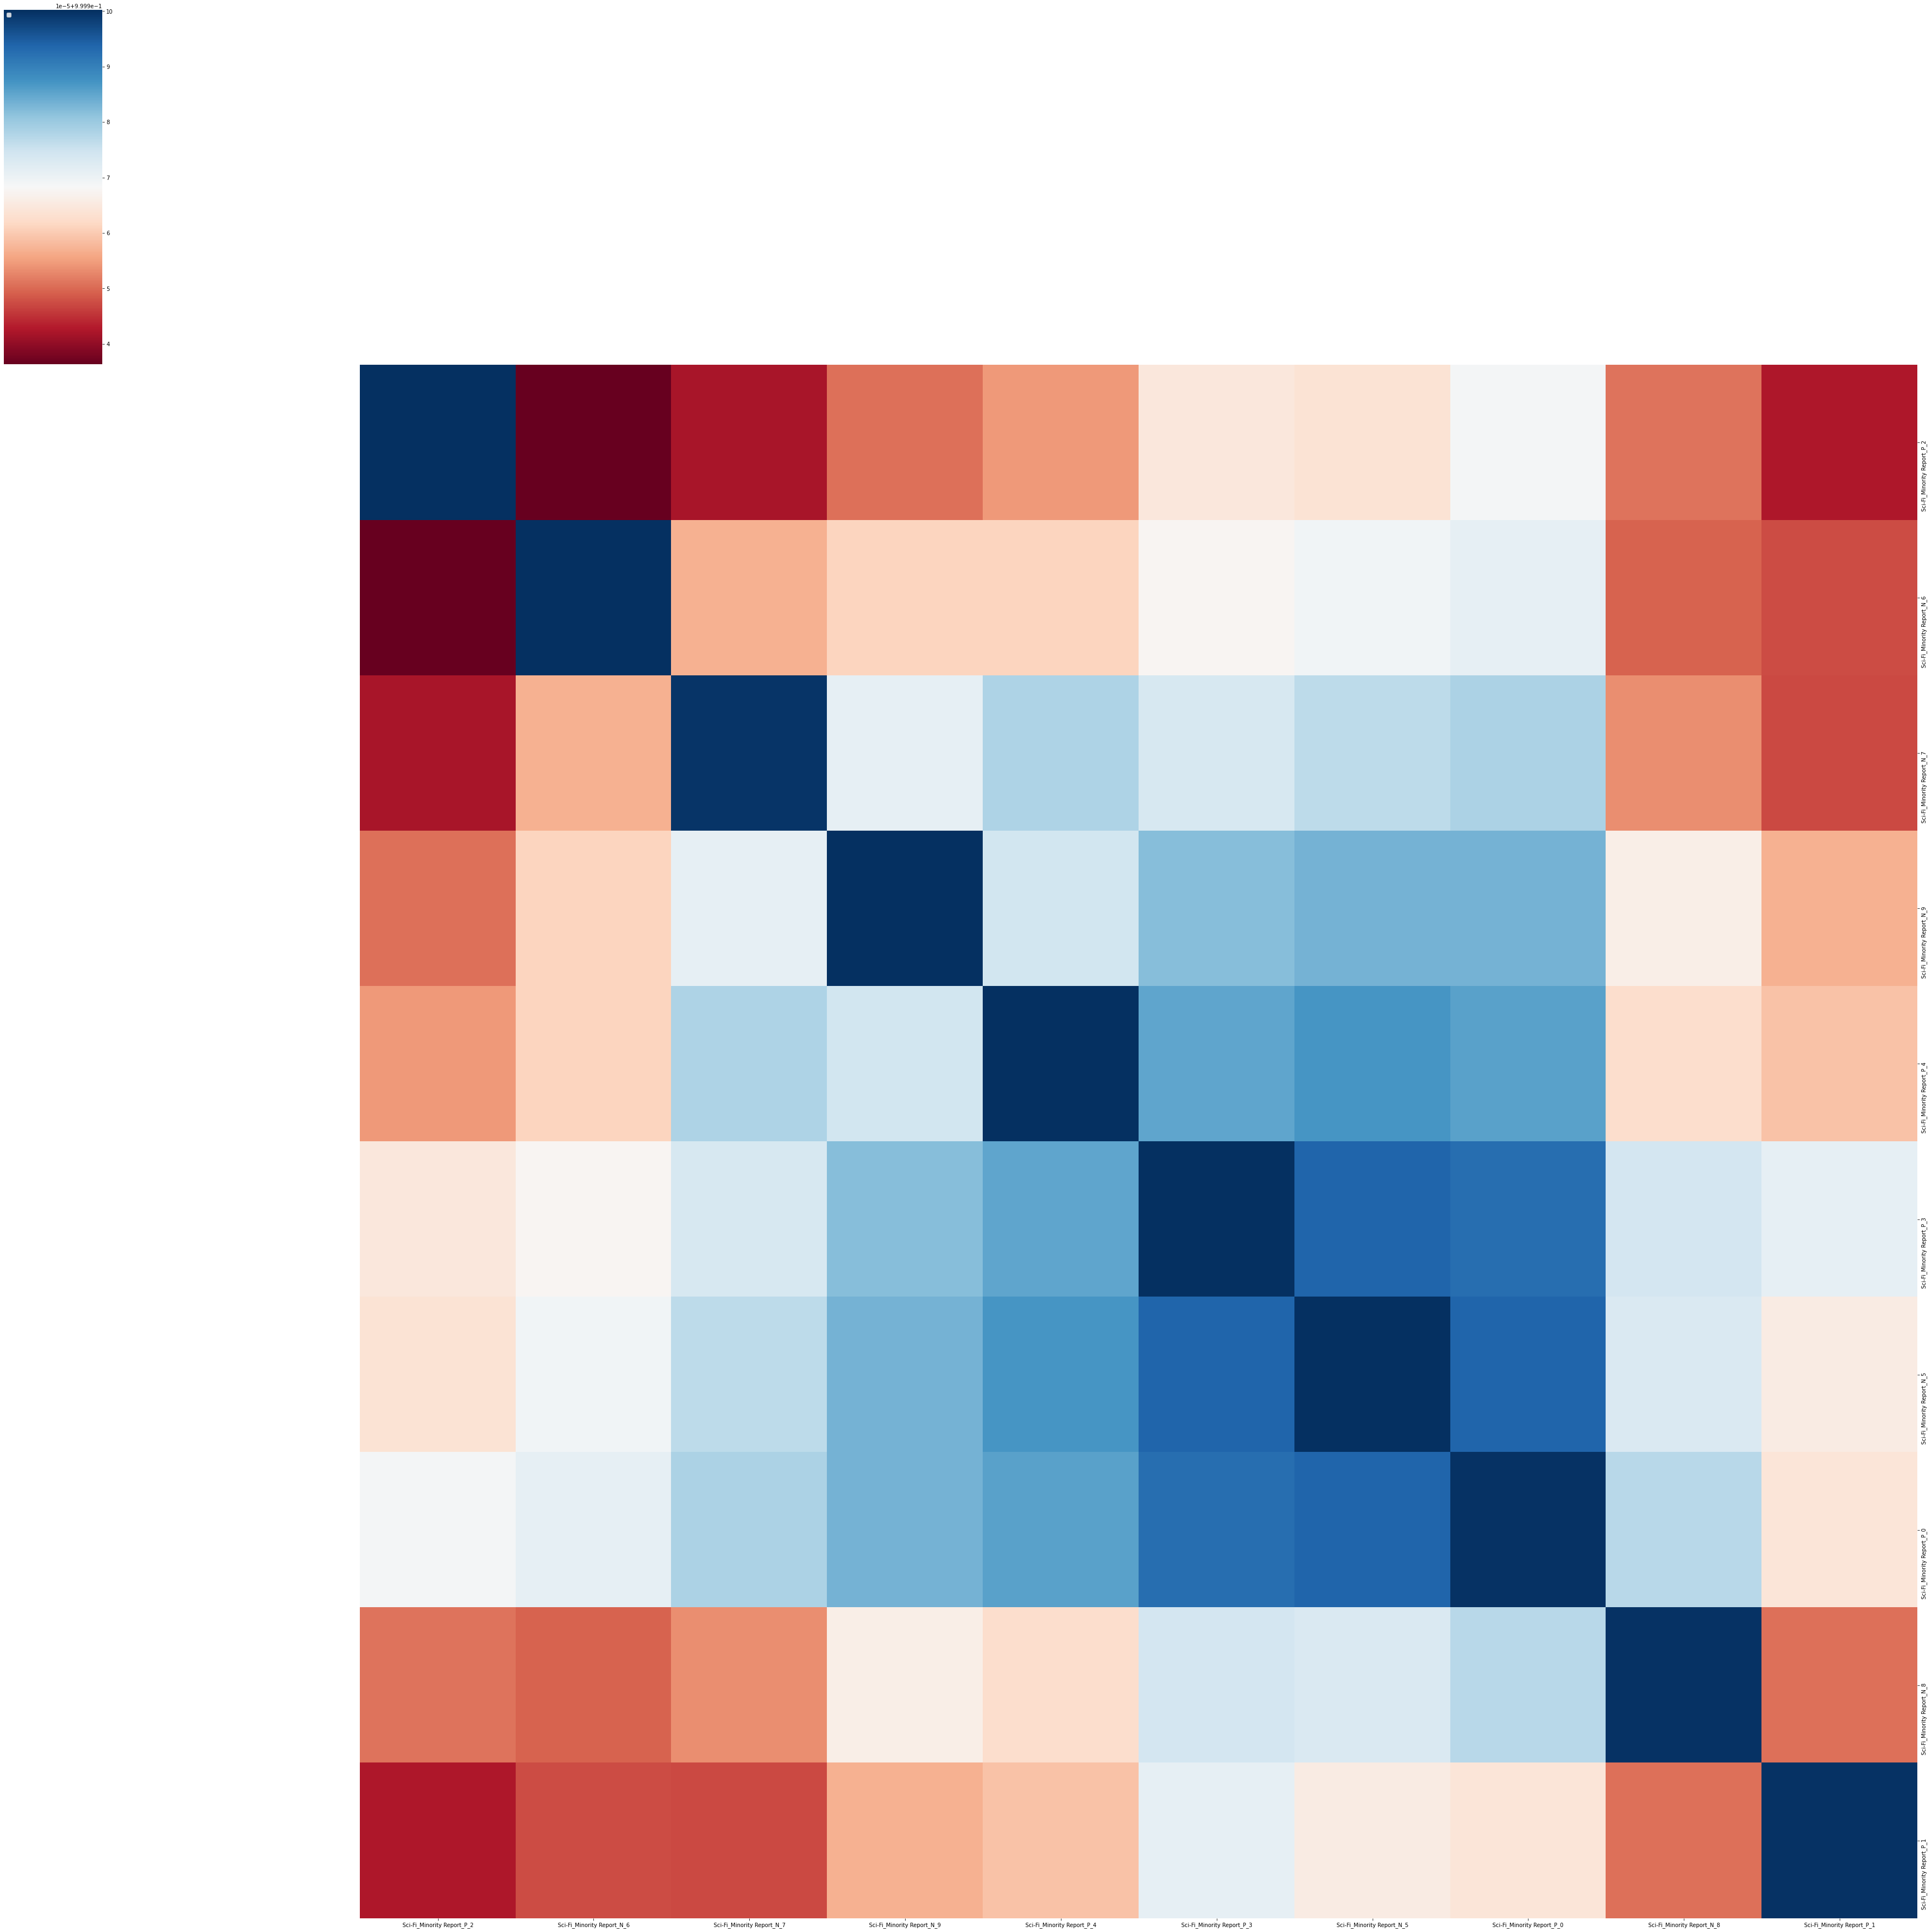

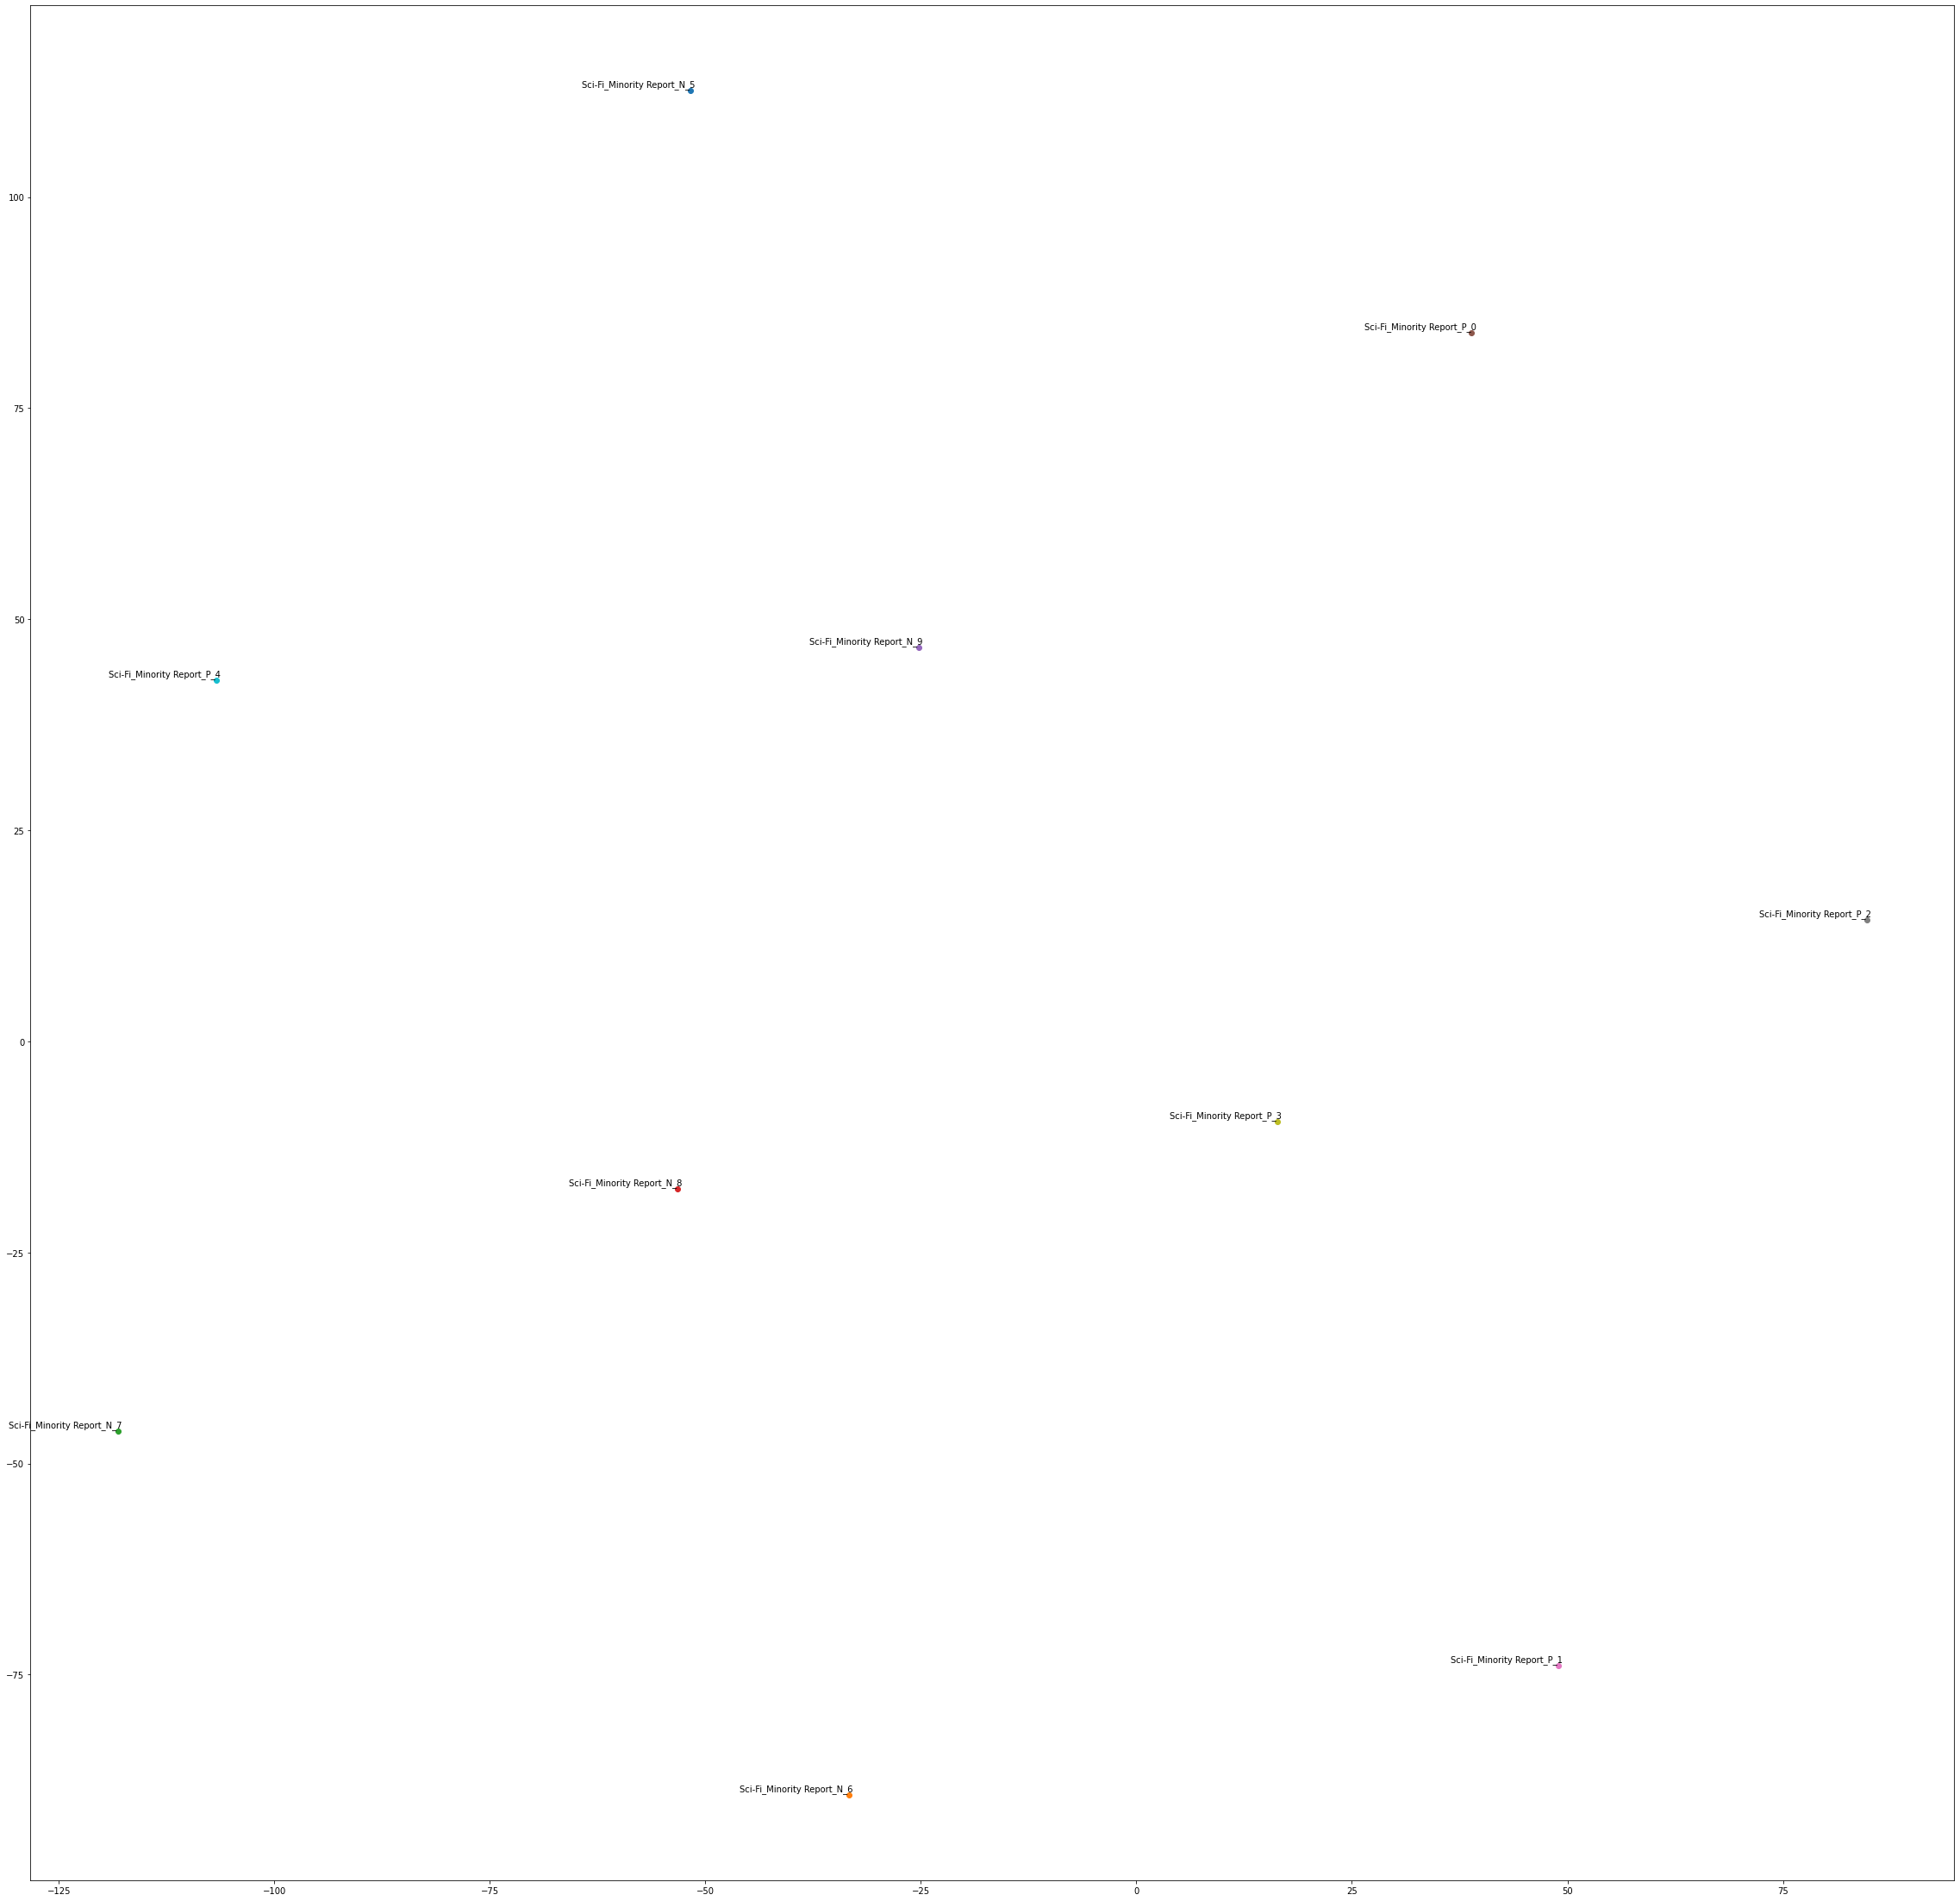

In [216]:
run_doc2vec_experiment(documents, clean_method, 100, 'Doc2Vec_exp')

I'm curious why a Minority Report Review and a Legally Blonde Review look so much alike...

In [219]:
corpus_df

,DSI_Title,Text,Submission File Name,Student Name,Genre of Movie,Review Type (pos or neg),Movie Title,Descriptor,Doc_ID
Doc_ID,,,,,,,,,
5,RSV_Doc6_MinorityReport,"Minority Report , directed by Steven Spielberg...",NaN,RS,Sci-Fi,Negative,Minority Report,Sci-Fi_Minority Report_N_5,5
6,RSV_Doc7_MinorityReport,Once again this year we are graced with a futu...,NaN,RS,Sci-Fi,Negative,Minority Report,Sci-Fi_Minority Report_N_6,6
7,RSV_Doc8_MinorityReport,"Set in the year 2054, Steven Spielberg's Minor...",NaN,RS,Sci-Fi,Negative,Minority Report,Sci-Fi_Minority Report_N_7,7
8,RSV_Doc9_MinorityReport,"In Minority Report, a futuristic thriller set ...",NaN,RS,Sci-Fi,Negative,Minority Report,Sci-Fi_Minority Report_N_8,8
9,RSV_Doc10_MinorityReport,"What new hell is this? In the shallow, noisy a...",NaN,RS,Sci-Fi,Negative,Minority Report,Sci-Fi_Minority Report_N_9,9
0,RSV_Doc1_MinorityReport,Steven Spielberg’s Minority Report realizes th...,NaN,RS,Sci-Fi,Positive,Minority Report,Sci-Fi_Minority Report_P_0,0
1,RSV_Doc2_MinorityReport,In the movie it’s the future (2054) and we now...,NaN,RS,Sci-Fi,Positive,Minority Report,Sci-Fi_Minority Report_P_1,1
2,RSV_Doc3_MinorityReport,"In the year 2054, at the Department of Precrim...",NaN,RS,Sci-Fi,Positive,Minority Report,Sci-Fi_Minority Report_P_2,2
3,RSV_Doc4_MinorityReport,“Minority Report” is the most un-Spielberg fil...,NaN,RS,Sci-Fi,Positive,Minority Report,Sci-Fi_Minority Report_P_3,3
